In [43]:
import pandas as pd

df = pd.read_csv('./covid/covid-monthly-cases.csv')

states = sorted(list(df.state.unique()))
years = sorted(list(df.submission_year.unique()))
months = sorted(list(df.submission_month.unique()))

df

,state,submission_year,submission_month,new_case,new_death,population,pnew_case,pnew_death
0,AK,2020,1,0.0,0.0,733391,0.000000,0.000000
1,AK,2020,2,0.0,0.0,733391,0.000000,0.000000
2,AK,2020,3,128.0,6.0,733391,0.000175,0.000008
3,AK,2020,4,227.0,3.0,733391,0.000310,0.000004
4,AK,2020,5,108.0,4.0,733391,0.000147,0.000005
...,...,...,...,...,...,...,...,...
1219,WY,2021,8,9897.0,82.0,576851,0.017157,0.000142
1220,WY,2021,9,15466.0,138.0,576851,0.026811,0.000239
1221,WY,2021,10,12324.0,178.0,576851,0.021364,0.000309
1222,WY,2021,11,8163.0,254.0,576851,0.014151,0.000440


In [140]:
from functools import reduce
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

def is_zero(v, zero=0.00001):
    if np.abs(v) < zero:
        return 0.0
    return v

def adjust(df):
    for r, s in enumerate(df.sum(axis=1)):
        if s == 0:
            df.iloc[r,:] = 1
    return df

def normalize(df):
    return pd.DataFrame([df.iloc[r,:] * s
                         for r, s in enumerate(1 / df.sum(axis=1))],
                        index=df.index, columns=df.columns)
def get_M(yr, mo, field):
    def get_stats(i, j):
        num = stats[states[i]]
        den = stats[states[j]]
        if den == 0:
            if num == 0:
                return 0
            else:
                return 1.0
        else:
            return num / den
        
    q = (df.submission_year==yr) & (df.submission_month==mo)
    stats = {r.state: r[field] for _, r in df[q][['state', field]].iterrows()}
    
    M = pd.DataFrame([[get_stats(i, j) for j in range(len(states))] 
                      for i in range(len(states))], columns=states, index=states)
    M = adjust(M)
    return M

def get_p(yr, mo, field):
    q = (df.submission_year==yr) & (df.submission_month==mo)
    p = np.array([r[field] for _, r in df[q][['state', field]].iterrows()])
    return p

def get_r(yr, mo, stat_field, pred_field):
    M = get_M(yr, mo, stat_field)
    p = get_p(yr, mo, pred_field)
    
    model = LinearRegression()
    model.fit(M, p)
    
    return pd.DataFrame({f'{yr:04}_{mo:02}': model.coef_}, index=states)

data_2020 = [get_r(2020, mo, 'pnew_case', 'pnew_death') for mo in range(1, 13)]
data_2021 = [get_r(2021, mo, 'pnew_case', 'pnew_death') for mo in range(1, 13)]
data = data_2020 + data_2021

rating_df = reduce(lambda x, y: x.join(y), data)
rating_df = pd.DataFrame(MinMaxScaler((0, 1)).fit_transform(rating_df), columns=rating_df.columns, index=states)

<ipython-input-141-842c9d5183b2>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(rating_df.T.index, rotation=45)


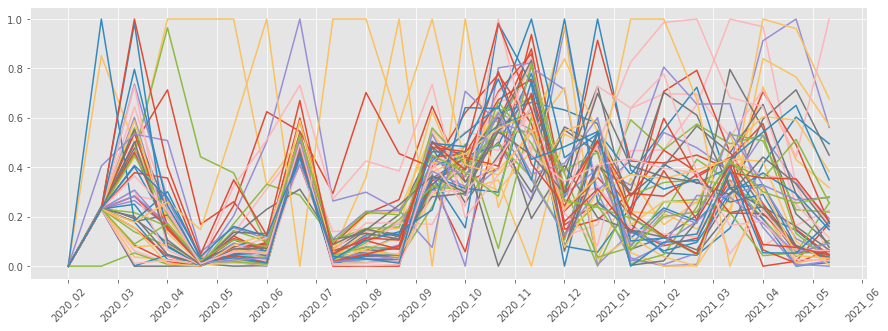

In [141]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

ax = rating_df.T.plot(kind='line', figsize=(15, 5), legend=False)
_ = ax.xaxis.set_major_locator(plt.MaxNLocator(len(rating_df.T.index)))
_ = ax.set_xticklabels(rating_df.T.index, rotation=45)

In [167]:
from itertools import chain

ascending = True
top = 3

ratings = [(rating_df.sort_values([f], ascending=ascending)[f], f) for f in rating_df.columns]
ratings = [(list(chain(*list(zip(r.index[0:top], r.iloc[0:top].values)))) + [f]) for r, f in ratings]
columns = list(chain(*[[f'state{i}', f'p{i}'] for i  in range(1, top + 1)])) + ['year']

ratings = pd.DataFrame(ratings, columns=columns)
ratings.index = ratings['year']
ratings = ratings.drop(columns=['year'])

ratings

,state1,p1,state2,p2,state3,p3
year,,,,,,
2020_01,AK,0.0,NC,0.000000,ND,0.000000
2020_02,MA,0.0,AR,0.231556,MS,0.231556
2020_03,NJ,0.0,MI,0.000896,NY,0.011514
2020_04,NJ,0.0,MA,0.007625,RI,0.009361
2020_05,DC,0.0,RI,0.000627,IL,0.000926
2020_06,AZ,0.0,MS,0.013322,FL,0.017173
2020_07,FL,0.0,AZ,0.002170,LA,0.003583
2020_08,VT,0.0,MA,0.287238,NJ,0.311431
2020_09,ND,0.0,SD,0.004733,WI,0.009050
